# Making the latitude / latitude points to sample across DC

### Use Python3

First we make a list of latitudes and longitudes. My latitude list will go from top left corner to top right corner, and the longitude list reads from top left corner to bottom left corner - a bit like the axes on a graph, but flipped. 

I found my starting and end points by dropping a pin on Google Maps at the widest parts and tallest parts of D.C.

Unfortunately, because the API connection with http://data.fcc.gov/api/ kept timing out when I tried to feed it 44 x 44 locations, I had to run it twice with 22x22 locations, with the second set offset by 0.005 (degrees?).

In [1]:
# Make latitude list
lat_start1 = 38.791547  # First set
lat_start2 = 38.796547 # Second set with an offset of 0.005 from 'lat_start'

latitude1 = []
latitude2 = []


def get_latitudes(lat_start, lat_list):
    total = 0
    while total < 22:
        lat_list.append(lat_start)
        lat_start += 0.01
        total += 1

get_latitudes(lat_start1, latitude1)
get_latitudes(lat_start2, latitude2)

In [2]:
# make longitude list

lon_start1 = -77.119672
lon_start2 = -77.124672

longitude1 = []
longitude2 = []

def get_longitude(lon_start, lon_list):
    total = 0
    while total < 22:
        lon_list.append(lon_start)
        lon_start += 0.01
        total += 1

get_longitude(lon_start1, longitude1)
get_longitude(lon_start2, longitude2)

In [3]:
## Check they are the length expected
print(len(latitude1))
print(len(latitude2))
print(len(longitude1))
print(len(longitude2))

22
22
22
22


### Collect address information only from points that are within DC
The http://data.fcc.gov/ API returns an address when given an latitude and longitude

In [4]:
from time import sleep
from urllib.request import urlopen
from json import load 
from geopy.geocoders import Nominatim
import codecs

reader = codecs.getreader("utf-8")
base_url = 'http://data.fcc.gov/api/block/find?format=json&latitude=' #28.35975&longitude=-81.421988&showall=true'
geolocator = Nominatim()

In [5]:
total_list1 = []
total_list2 = []

In [6]:
def make_points(lat_list, long_list, total_list):
    for i in lat_list:
        for j in long_list:
            url = (base_url + str(i) + '&longitude=' + str(j) + '&showall=true/')
            response = urlopen(url)
            json_obj = load(reader(response))
            if json_obj['State']['name'] == 'District of Columbia':
                total_list.append(make_dict(i, j, json_obj))
        sleep(10)
    sleep(10)
            

def make_dict(i, j, json_obj):
    latlong = {}

    latlong['latitude'] = i
    latlong['longitude'] = j
    latlong['State'] = json_obj['State']['name']
    latlong['Block'] = json_obj['Block']['FIPS']
    coords = (str(i) + ',' +str(j))
    location = geolocator.reverse(coords)
    latlong['address'] = location.address

    return latlong

In [7]:
make_points(latitude1, longitude1, total_list1)

In [8]:
len(total_list1)

181

Because the connection is somewhat delicate (as I mentioned before), wait a while before running it again. Sometimes I get a timeout error, while other times I get a server or connection error. In these cases I just wait a bit and then try again. Then it works. 

If you come across a better way of doing this (perhaps a way to geocode that is not so delicate) please feel free to let me know or submit a pull request or something :D

In [9]:
make_points(latitude2, longitude2, total_list2)

In [10]:
len(total_list2)

183

### Make two dataframes from the two lists of dictionaries, and then concatenate them together

In [11]:
import pandas as pd
points1 = pd.DataFrame(total_list1)
points2 = pd.DataFrame(total_list2)
dfs = [points1, points2]
points = pd.concat(dfs)

In [12]:
points.head()

Block                 State  \
0  110010109002039  District of Columbia   
1  110010109002039  District of Columbia   
2  110010109002008  District of Columbia   
3  110010073011033  District of Columbia   
4  110010073011124  District of Columbia   

                                             address   latitude  longitude  
0  Anacostia Freeway, Washington, District of Col...  38.801547 -77.029672  
1  Anacostia Freeway, Washington, District of Col...  38.811547 -77.029672  
2  Anacostia Freeway, Washington, District of Col...  38.811547 -77.019672  
3  Laboratory Road Southwest, Blue Plains - DC Wa...  38.821547 -77.029672  
4  Laboratory Road Southwest, Blue Plains - DC Wa...  38.821547 -77.019672

In [13]:
len(points)

364

In [14]:
points.to_csv('./data/notValidatedPoints.csv', index=False)

Open the CSV and arrange your columns so your Lat and Lon column are side by side:

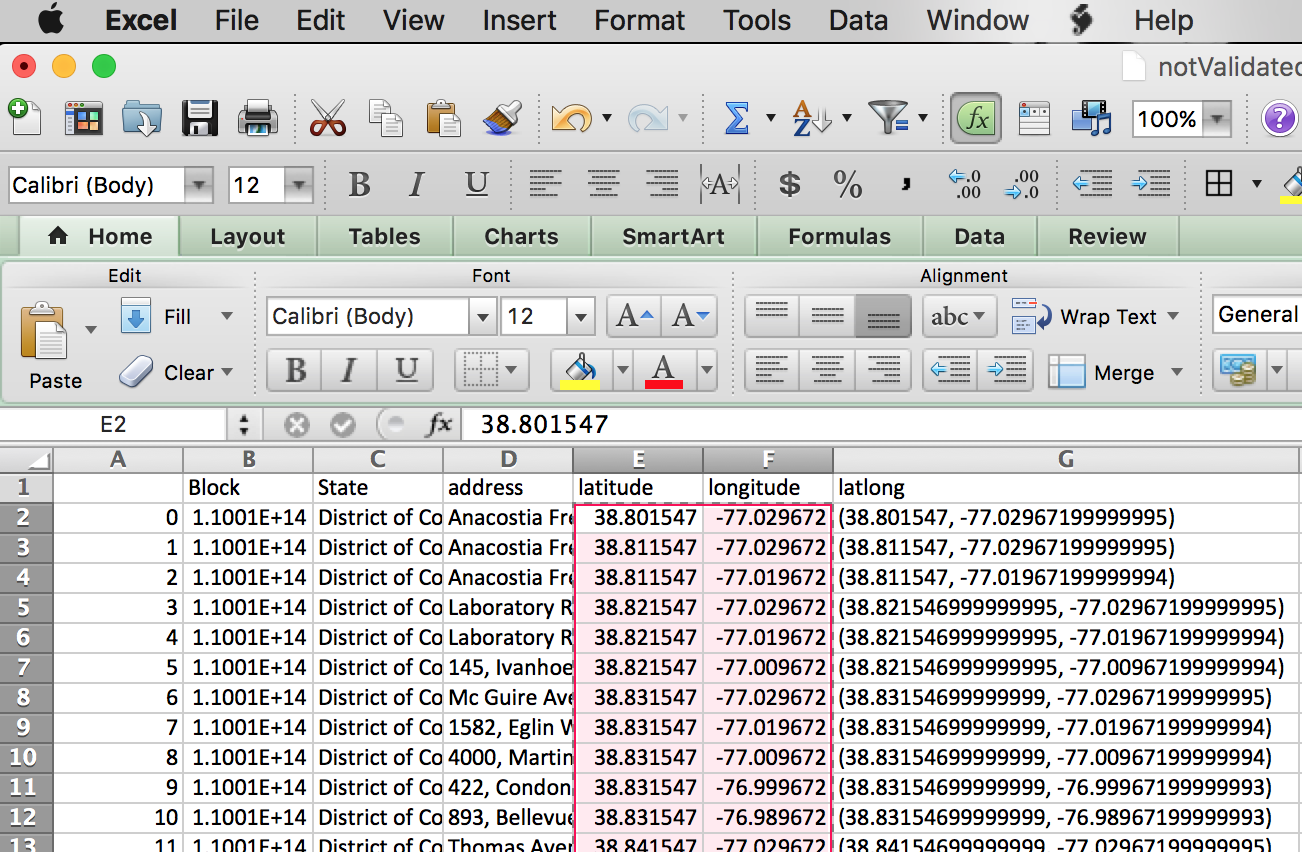

In [15]:
from IPython.display import Image
Image(filename='/Users/jenniferstark/Documents/Repositories/2016-03-wapo-uber/images/notValidatedPointsCSV.png')

Copy and paste the latitude and longitude into http://www.hamstermap.com/quickmap.php

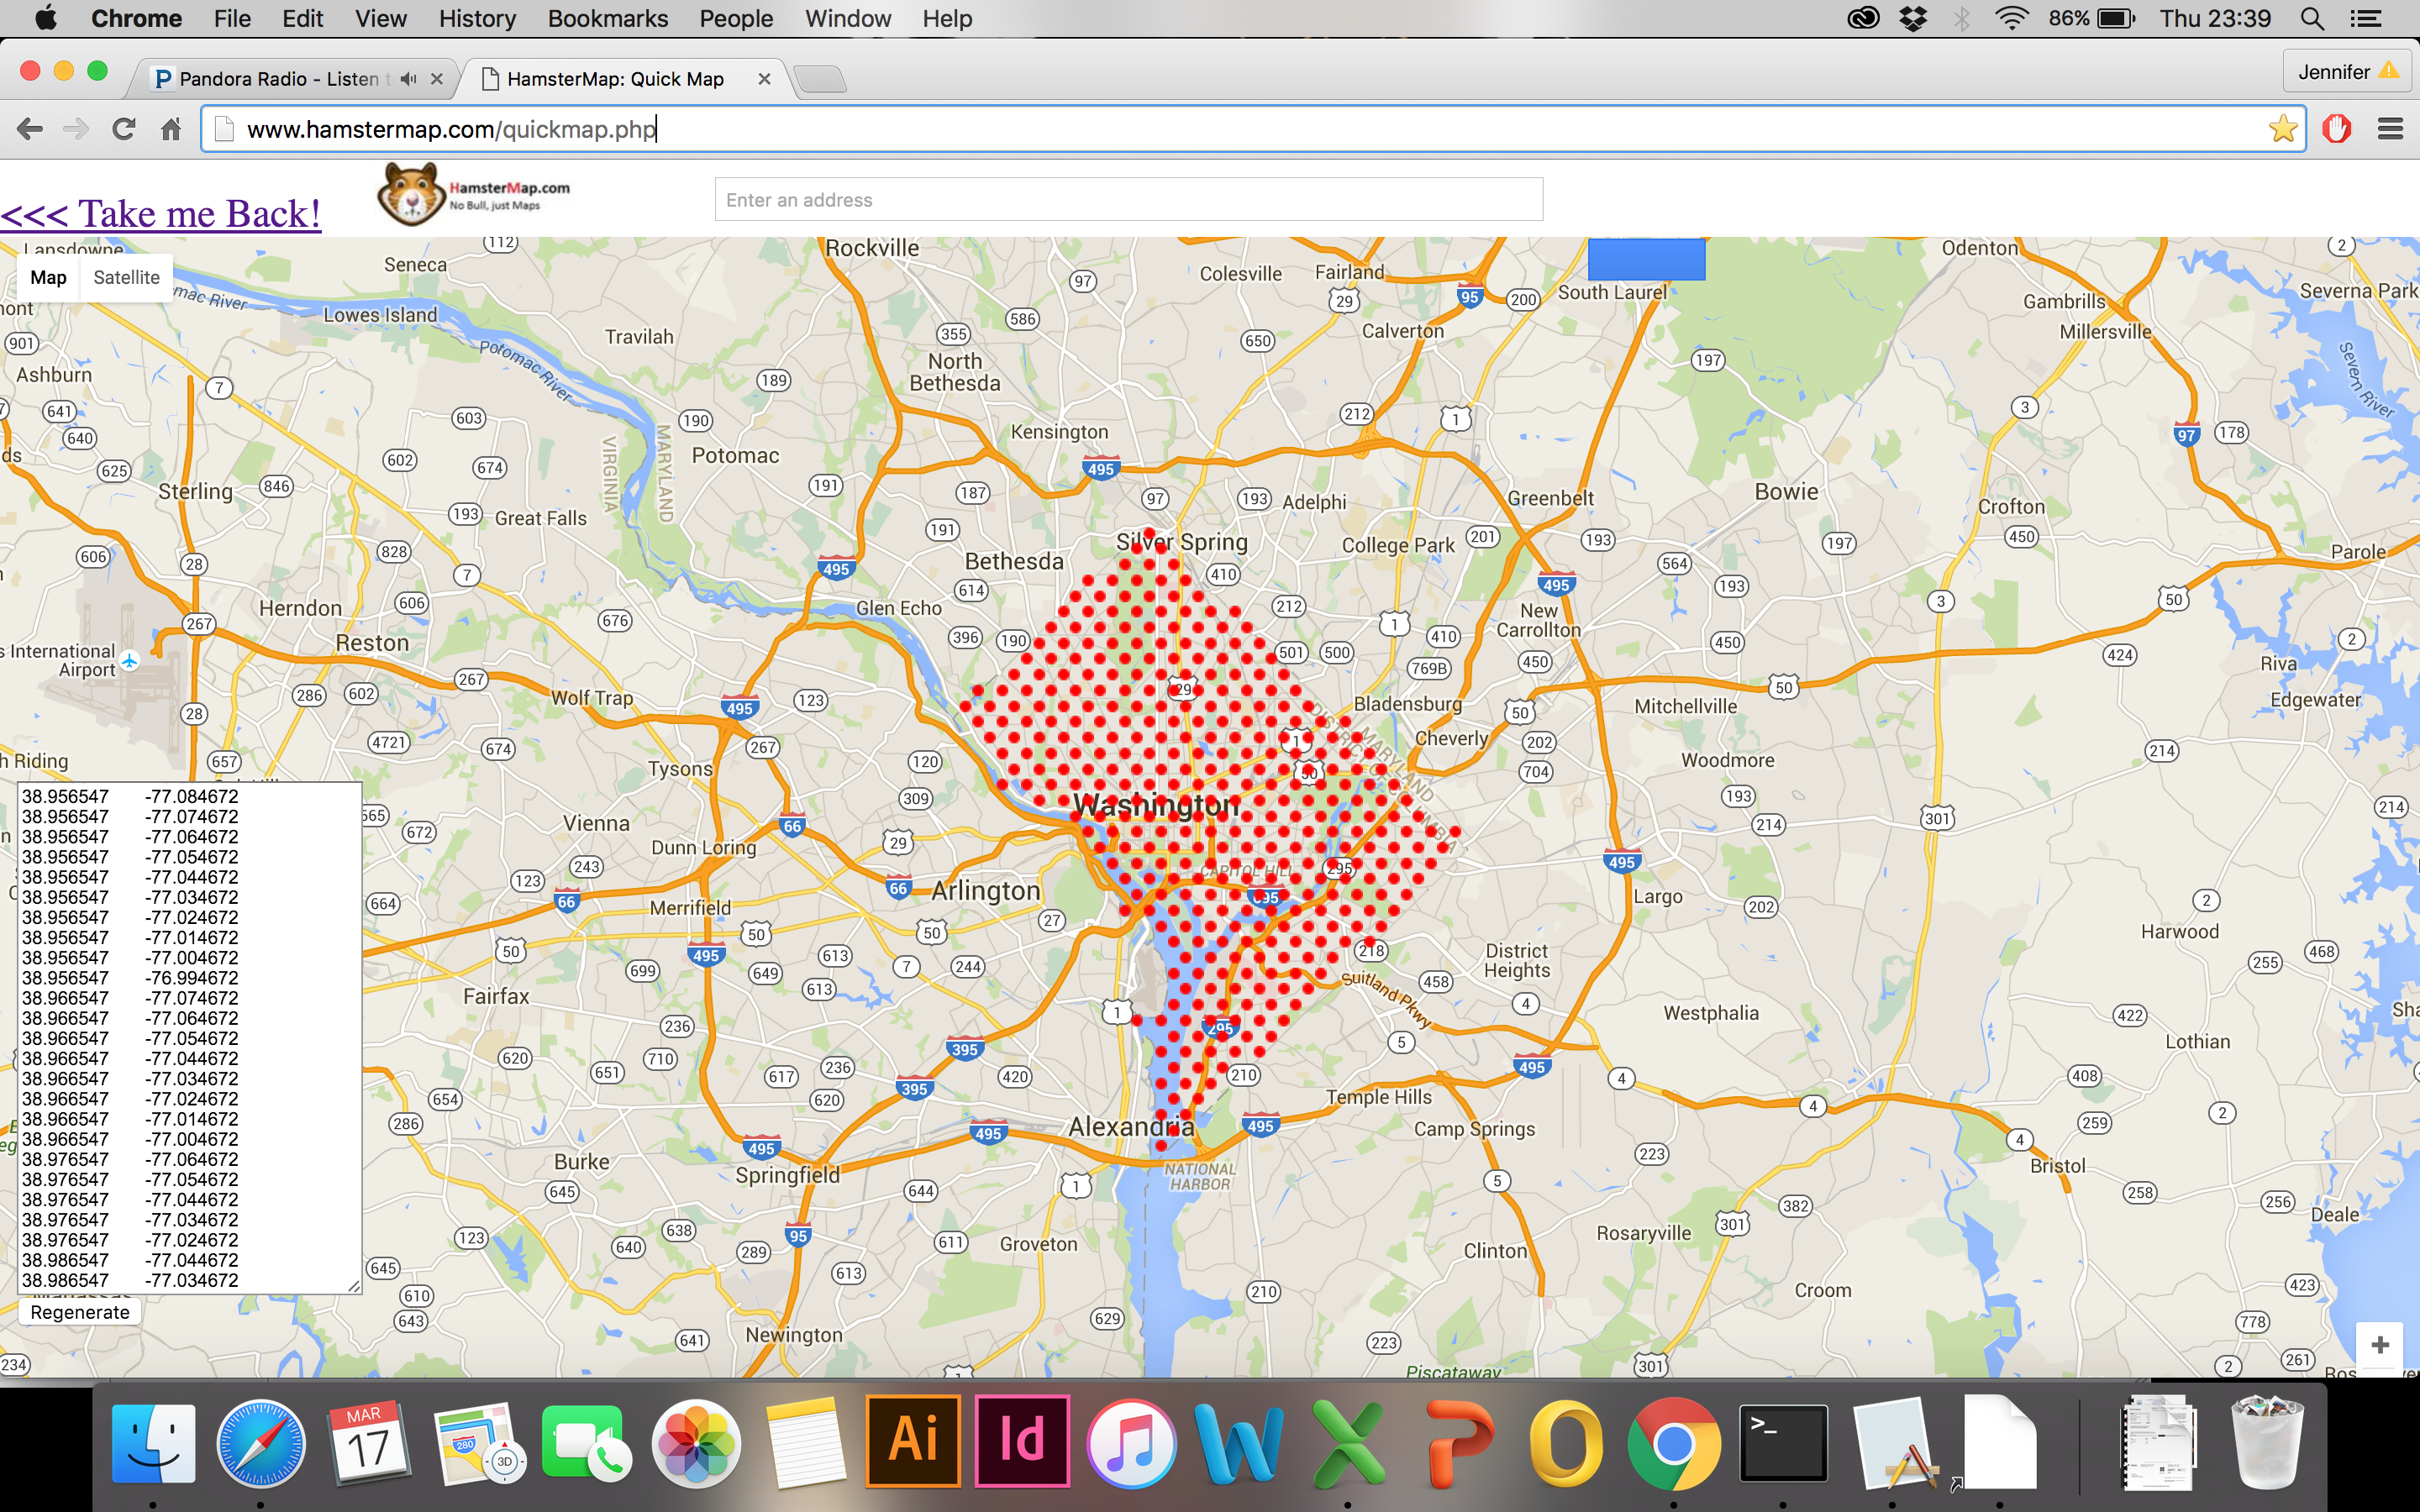

In [16]:
Image(filename='/Users/jenniferstark/Documents/Repositories/2016-03-wapo-uber/images/notValidatedPointsMAP.png')

Nice! Take a good look. There are points in water and parkland. It is not likely that you can hail an Uber in some of these places. Therefore, we will validate the addresses. 

## Validate addresses

In [17]:
from address import AddressParser

In [18]:
# A little bit about how it is used:
'''
address = ap.parse_address('Wolfe Street, Alexandria Historic District, \
                           Alexandria, Alexandria City, Virginia, 22314, United States of America')

print("Address is: {0} {1} {3}".format(address.house_number,
      address.street_prefix, address.street, address.street_suffix))

'''


'\naddress = ap.parse_address(\'Wolfe Street, Alexandria Historic District,                            Alexandria, Alexandria City, Virginia, 22314, United States of America\')\n\nprint("Address is: {0} {1} {3}".format(address.house_number,\n      address.street_prefix, address.street, address.street_suffix))\n\n'

In [19]:
## Tag all bad addresses!

ap = AddressParser()

valid = []

def validate_address(df):
    yeses = 0
    nos = 0
    for index, i in enumerate(df.address):
        address = ap.parse_address(i)
        if address.house_number != None and address.street_prefix != None:
            yeses += 1
            valid.append(1)
        else:
            nos += 1
            valid.append(0)
    return yeses, nos

In [20]:
validate_address(points)

(234, 130)

Reading the output, we see it returned 234 yeses (valid addresses) and 130 nos (invalid addresses). 

In [21]:
# we can now add this list as a colunm in our dataframe, and use it as 
# a mask to select only valid addresses

points['valid'] = valid

In [22]:
points.head(10)

Block                 State  \
0  110010109002039  District of Columbia   
1  110010109002039  District of Columbia   
2  110010109002008  District of Columbia   
3  110010073011033  District of Columbia   
4  110010073011124  District of Columbia   
5  110010109001001  District of Columbia   
6  110010073011010  District of Columbia   
7  110010073011078  District of Columbia   
8  110010098071011  District of Columbia   
9  110010098021001  District of Columbia   

                                             address   latitude  longitude  \
0  Anacostia Freeway, Washington, District of Col...  38.801547 -77.029672   
1  Anacostia Freeway, Washington, District of Col...  38.811547 -77.029672   
2  Anacostia Freeway, Washington, District of Col...  38.811547 -77.019672   
3  Laboratory Road Southwest, Blue Plains - DC Wa...  38.821547 -77.029672   
4  Laboratory Road Southwest, Blue Plains - DC Wa...  38.821547 -77.019672   
5  145, Ivanhoe Street Southwest, Bellevue, Washi...  38.821547 -77.009672   
6  Mc Guire Avenue Southeast, Washington, Distric...  38.831547 -77.029672   
7  1582, Eglin Way Southwest, Washington, Distric...  38.831547 -77.019672   
8  4000, Martin Luther King Jr Avenue Southwest, ...  38.831547 -77.009672   
9  422, Condon Terrace Southeast, Washington High...  38.831547 -76.999672   

   valid  
0      0  
1      0  
2      0  
3      0  
4      0  
5      1  
6      0  
7      1  
8      1  
9      1

In [23]:
#make df that ONLY contains valid points
points_valid_df = points[points.valid == 1]

In [24]:
len(points_valid_df)

234

## Check which tracts each point is in / getting count for points in each tract

`'geodata'` has a field `'GEOID'` that indicates the tract as an 11-digit integer (eg 11001008002, len=11)

`'points_valid_df'` has a field `'Block'` that incidates the block within the tract with a 15-digit integer (eg 110010109001001, len=15), with the first 11 identicle to `'GEOID'`

In [26]:
geodata = pd.read_csv('./data/geodata.csv')  # created in `'get_census_data.ipynb'`

In [27]:
# add a column where all tract counts are zero
geodata['tract_count'] = 0

def get_tract_count(geodf, pointsdf):
    for i in pointsdf.Block:
        for index, j in enumerate(geodf.GEOID):
            if str(j) == str(i[:11]):
                geodf.tract_count[index]+= 1
                
get_tract_count(geodata, points_valid_df)

/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
geodata

AREALAND  AREAWATER  BASENAME    CENTLAT    CENTLON  COUNTY FUNCSTAT  \
0      579629          0     80.02  38.891542 -76.982757       1        S   
1      535254          0     78.09  38.901540 -76.932195       1        S   
2      543460          0     25.01  38.944651 -77.031735       1        S   
3      300647          0     29.00  38.933848 -77.029913       1        S   
4      603721          0     25.02  38.939057 -77.030145       1        S   
5      296909          0     31.00  38.930619 -77.025423       1        S   
6      338424          0     82.00  38.891831 -77.000604       1        S   
7     2010229       5298     23.02  38.933896 -77.010878       1        S   
8      693964        566     22.02  38.948846 -77.013869       1        S   
9      452924          0     27.01  38.934450 -77.041686       1        S   
10    1026343          0     95.04  38.940934 -76.993095       1        S   
11     726388          0     21.02  38.955786 -77.014233       1        S   
12     412610          0     23.01  38.942590 -77.016574       1        S   
13     415172          0     22.01  38.949134 -77.023293       1        S   
14    2112828     103954     26.00  38.945272 -77.042532       1        S   
15     290283          0     81.00  38.893171 -76.992527       1        S   
16    1430008      32262     90.00  38.922909 -76.954029       1        S   
17     486440      16260     27.02  38.930173 -77.041794       1        S   
18     322795          0     80.01  38.896173 -76.986652       1        S   
19     401370          0     79.01  38.896560 -76.980431       1        S   
20     247945          0     79.03  38.896425 -76.974302       1        S   
21     556234          0     24.00  38.941784 -77.022405       1        S   
22     171911          0     28.01  38.934948 -77.034517       1        S   
23     229694          0     28.02  38.929434 -77.034633       1        S   
24     210638          0     30.00  38.928869 -77.029953       1        S   
25     292371          0     37.00  38.922861 -77.034333       1        S   
26     356113          0     38.00  38.921635 -77.039179       1        S   
27     302795          0     92.04  38.923414 -76.998772       1        S   
28    1835339        453     91.02  38.918784 -76.988990       1        S   
29     640834          0     92.01  38.928775 -76.998937       1        S   
..        ...        ...       ...        ...        ...     ...      ...   
149    788162          0     14.01  38.965304 -77.070608       1        S   
150    889584        137     10.02  38.938422 -77.078887       1        S   
151    737121     124915     77.08  38.885565 -76.961579       1        S   
152   4686643      12091     15.00  38.973502 -77.054078       1        S   
153    895209          0     14.02  38.960605 -77.063093       1        S   
154   1647257     640778      8.02  38.910795 -77.087561       1        S   
155   1676582          0     11.00  38.957243 -77.077673       1        S   
156   1218245          0     12.00  38.946226 -77.070524       1        S   
157   2454383          0     10.01  38.948955 -77.088465       1        S   
158   1369578          0     76.04  38.866092 -76.963801       1        S   
159    842852          0     77.07  38.877945 -76.935343       1        S   
160    453791          0     76.05  38.866043 -76.975257       1        S   
161   1017266       1059     77.03  38.886222 -76.947507       1        S   
162   2665665      35624     16.00  38.984549 -77.037835       1        S   
163   1136289      31934     18.03  38.967078 -77.039734       1        S   
164    749889          0    105.00  38.881853 -77.013379       1        S   
165    293676        158      7.02  38.924113 -77.077819       1        S   
166   1084530         61    103.00  38.976156 -77.027187       1        S   
167    632723       2202     20.01  38.959350 -77.035940       1        S   
168    839831       4303     78.04  38.895444 -76.931344       1        S   
1

In [29]:
# Which are the tracts that are NOT represented in our dataset? 
# The ones not represented likley due to the point that landed in the 
# tract was an invalid address, or points missed the tract completely
# due to the tract being too tiny
geodata.BASENAME[geodata.tract_count == 0]

5       31.00
9       27.01
12      23.01
15      81.00
19      79.01
24      30.00
25      37.00
27      92.04
30      92.03
32      87.02
36      83.02
37      83.01
40      88.02
41      89.03
44      93.02
57      66.00
60      56.00
61      48.02
62      49.02
65     110.00
66      59.00
67      58.00
72      47.01
74      50.02
77      74.06
86      65.00
91      49.01
102     68.01
103     68.02
109     99.03
113     42.02
114     42.01
117     95.07
118     40.01
122     74.03
128      5.01
134     52.01
150     10.02
151     77.08
165      7.02
177     78.03
Name: BASENAME, dtype: float64

In [30]:
## Now to add centerpoints to the points_valid_df from tracts that are currently
## not represented. THEN we'll have to run 'validate_address()' again in case
## these new centerpoints are in stupid places :D

## first get a list of lat-lons for the tract centerpoints, 
## Then create a list of dictionaries of the addresses for each lat-lon
## then turn it into a df before concatenating it with `'points_valid_df'`

CENTlat = geodata.CENTLAT[geodata.tract_count == 0]
CENTlon = geodata.CENTLON[geodata.tract_count == 0]

zipCenterPoints = list(zip(CENTlat, CENTlon))

In [31]:
zipCenterPoints

[(38.930618700000004, -77.025423200000006),
 (38.934450299999995, -77.041685700000002),
 (38.942589599999998, -77.016573800000003),
 (38.893171000000002, -76.992527199999998),
 (38.896559699999997, -76.980431199999998),
 (38.928868900000005, -77.029952500000007),
 (38.922861400000002, -77.03433299999999),
 (38.923414000000001, -76.998772099999996),
 (38.9219735, -77.005495599999989),
 (38.914940600000001, -77.001453099999992),
 (38.896306099999997, -76.996652699999999),
 (38.897037299999994, -77.000800799999993),
 (38.903949799999999, -76.986678599999991),
 (38.904150799999996, -76.977728299999995),
 (38.925141199999999, -76.990848200000002),
 (38.887756500000002, -76.998273900000001),
 (38.900239399999997, -77.053840500000007),
 (38.906223700000005, -77.018903600000002),
 (38.905886799999998, -77.024393200000006),
 (38.868804100000006, -77.018003400000012),
 (38.8959945, -77.014946899999998),
 (38.897871299999998, -77.025001099999997),
 (38.904149299999993, -77.013650900000002),
 (38.

In [32]:
# `'add_centerpoints'` is a little different from `'all_points'` in that
# it iterates through specific pairs of lon-lat, not every possible 
# combination.

centerpointsList = []

def add_centerpoints(CenterPoints):
    for i, j in CenterPoints:
        url = (base_url + str(i) + '&longitude=' + str(j) + '&showall=true/')
        response = urlopen(url)
        json_obj = load(reader(response))
        centerpointsList.append(make_dict(i, j, json_obj))
    sleep(10)

add_centerpoints(zipCenterPoints)

In [33]:
centerpointsdf = pd.DataFrame(centerpointsList)

In [34]:
centerpointsdf

Block                 State  \
0   110010031001008  District of Columbia   
1   110010027013001  District of Columbia   
2   110010023012010  District of Columbia   
3   110010081002006  District of Columbia   
4   110010079014006  District of Columbia   
5   110010030001005  District of Columbia   
6   110010037001001  District of Columbia   
7   110010092042002  District of Columbia   
8   110010092031000  District of Columbia   
9   110010087022005  District of Columbia   
10  110010083021009  District of Columbia   
11  110010083012002  District of Columbia   
12  110010088023000  District of Columbia   
13  110010089031009  District of Columbia   
14  110010093021010  District of Columbia   
15  110010066001010  District of Columbia   
16  110010056002000  District of Columbia   
17  110010048021007  District of Columbia   
18  110010049022005  District of Columbia   
19  110010110002009  District of Columbia   
20  110010059001029  District of Columbia   
21  110010058001017  District of Columbia   
22  110010047012003  District of Columbia   
23  110010050023007  District of Columbia   
24  110010074061001  District of Columbia   
25  110010065002004  District of Columbia   
26  110010049012002  District of Columbia   
27  110010068011002  District of Columbia   
28  110010068022002  District of Columbia   
29  110010099032000  District of Columbia   
30  110010042021001  District of Columbia   
31  110010042012004  District of Columbia   
32  110010095071004  District of Columbia   
33  110010040013006  District of Columbia   
34  110010074031002  District of Columbia   
35  110010005011007  District of Columbia   
36  110010052014005  District of Columbia   
37  110010010023006  District of Columbia   
38  110010077082000  District of Columbia   
39  110010007021003  District of Columbia   
40  110010078034002  District of Columbia   

                                              address   latitude  longitude  
0   766, Lamont Street Northwest, Pleasant Plains,...  38.930619 -77.025423  
1   1807, Newton Street Northwest, Mount Pleasant,...  38.934450 -77.041686  
2   329, Upshur Street Northwest, Petworth, Bright...  38.942590 -77.016574  
3   243, 10th Street Northeast, Stanton Park, Capi...  38.893171 -76.992527  
4   500, 17th Street Northeast, Kingman Park, Capi...  38.896560 -76.980431  
5   3100, 13th Street Northwest, Petworth, Brightw...  38.928869 -77.029953  
6   2556, University Place Northwest, Columbia Hei...  38.922861 -77.034333  
7   515, Edgewood Street Northeast, Edgewood, Univ...  38.923414 -76.998772  
8   Glenwood Cemetery Mortuary Chapel, Bryant Stre...  38.921974 -77.005496  
9   314, Seaton Place Northeast, Eckington, Capito...  38.914941 -77.001453  
10  656, E Street Northeast, Stanton Park, Capitol...  38.896306 -76.996653  
11  536, 4th Street Northeast, Near Northeast, Was...  38.897037 -77.000801  
12  1278, Neal Street Northeast, Trinidad, Washing...  38.903950 -76.986679  
13  1737, Lang Place Northeast, Carver, Washington...  38.904151 -76.977728  
14  2724, 12th Street Northeast, Brookland, Univer...  38.925141 -76.990848  
15  600, Independence Avenue Southeast, Capitol Hi...  38.887757 -76.998274  
16  2514, I Street Northwest, Foggy Bottom, Washin...  38.900239 -77.053841  
17  474, Ridge Street Northwest, Logan Circle/Shaw...  38.906224 -77.018904  
18  907, M Street Northwest, Logan Circle, Washing...  38.905887 -77.024393  
19  221, 2nd Avenue, Fort McNair, Capitol Hill, Wa...  38.868804 -77.018003  
20  Jack's Famous Deli, E Street Northwest, Downto...  38.895995 -77.014947  
21  Mead Theatre Lab, G Street Northwest, Downtown...  38.897871 -77.025001  
22  Walker Jones Educational Campus, 1125, New Jer...  38.904149 -77.013651  
23  1227, N Street Northwest, Logan Circle/Shaw, L...  38.907278 -77.029318  
24  2502, Pomeroy Road Southeast, Hillsdale, Capit...  38.855554 -76.989558  
25  433, 2nd Street Southeast, Capitol Hill, Washi...  38.883848 -77.003338  
26  Carter Godwin

## Check that these new tract centerpoints are also valid addresses:

In [35]:
valid = []
validate_address(centerpointsdf)

(36, 5)

In [36]:
len(valid)

41

It returned 36 valid and 5 not valid. 

This means we have to go in and manually reposition the points in those 5 tracts to a road. 

In [37]:
##  Add the valid list to centerpointsdf and then concatenate with points_valid_df

centerpointsdf['valid'] = valid
dfs = [points_valid_df, centerpointsdf]
points_valid_df = pd.concat(dfs, ignore_index=True)

In [38]:
## Remove rows with invalid addresses
points_valid_df = points_valid_df[points_valid_df.valid == 1]

In [39]:
## Count how many points in each tract again:

geodata['tract_count'] = 0
get_tract_count(geodata, points_valid_df)

/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [40]:
## see which tracts are still not represented
geodata.BASENAME[geodata.tract_count == 0]

30      92.03
65     110.00
66      59.00
67      58.00
151     77.08
Name: BASENAME, dtype: float64

## Need to hand pick missing points for tracts still not represented

This site http://www.usboundary.com/Areas/Census%20Tract/District%20of%20Columbia/District%20of%20Columbia together with Google Maps can help you select new regions that are close to tract centerpoints but on a real road while stil within the boundaries of the tract.

1. See what tract is not yet represented above from geodata.BASENAME
2. copy-and-past the CENTLAT and CENTLON values from `'geodata'` dataframe on Google Maps to see where it is. Drop a new pin the closest you can to the original pin while still making sure it is a real address.
3. Use http://www.usboundary.com to make sure you're still within the bounds of the tract

In [41]:
## Hand write the lats and lons
## When I did this initially, I had 7 tracts missing...It may be that the script runs slightly differently each time,
## for example if the lat-lon sits on a tract border. 

NewLats = [38.921932,  38.872049, 38.896114, 38.898293, 38.871564, 38.885239, 38.881301]
NewLons = [-77.004047,-77.017347,-77.014956,-77.025012,-76.979019,-76.959831,-77.013393]

zipNewPoints = list(zip(NewLats, NewLons))

In [42]:
zipNewPoints

[(38.921932, -77.004047),
 (38.872049, -77.017347),
 (38.896114, -77.014956),
 (38.898293, -77.025012),
 (38.871564, -76.979019),
 (38.885239, -76.959831),
 (38.881301, -77.013393)]

In [43]:
## Get addresses for the new coordinates

newPointsList = []

def add_newpoints(newPoints):
    for i, j in newPoints:
        url = (base_url + str(i) + '&longitude=' + str(j) + '&showall=true/')
        response = urlopen(url)
        json_obj = load(reader(response))
        newPointsList.append(make_dict(i, j, json_obj))
    sleep(10)

add_newpoints(zipNewPoints)

In [44]:
## Make into a dataframe
newPointsdf = pd.DataFrame(newPointsList)

## Since newPoints were handpicked, there is no need to validate.

In [45]:
dfs = [points_valid_df, newPointsdf]
allpoints = pd.concat(dfs, ignore_index=True)
allpoints.to_csv('./data/allpoints.csv', index=None)

In [46]:
len(allpoints)

277

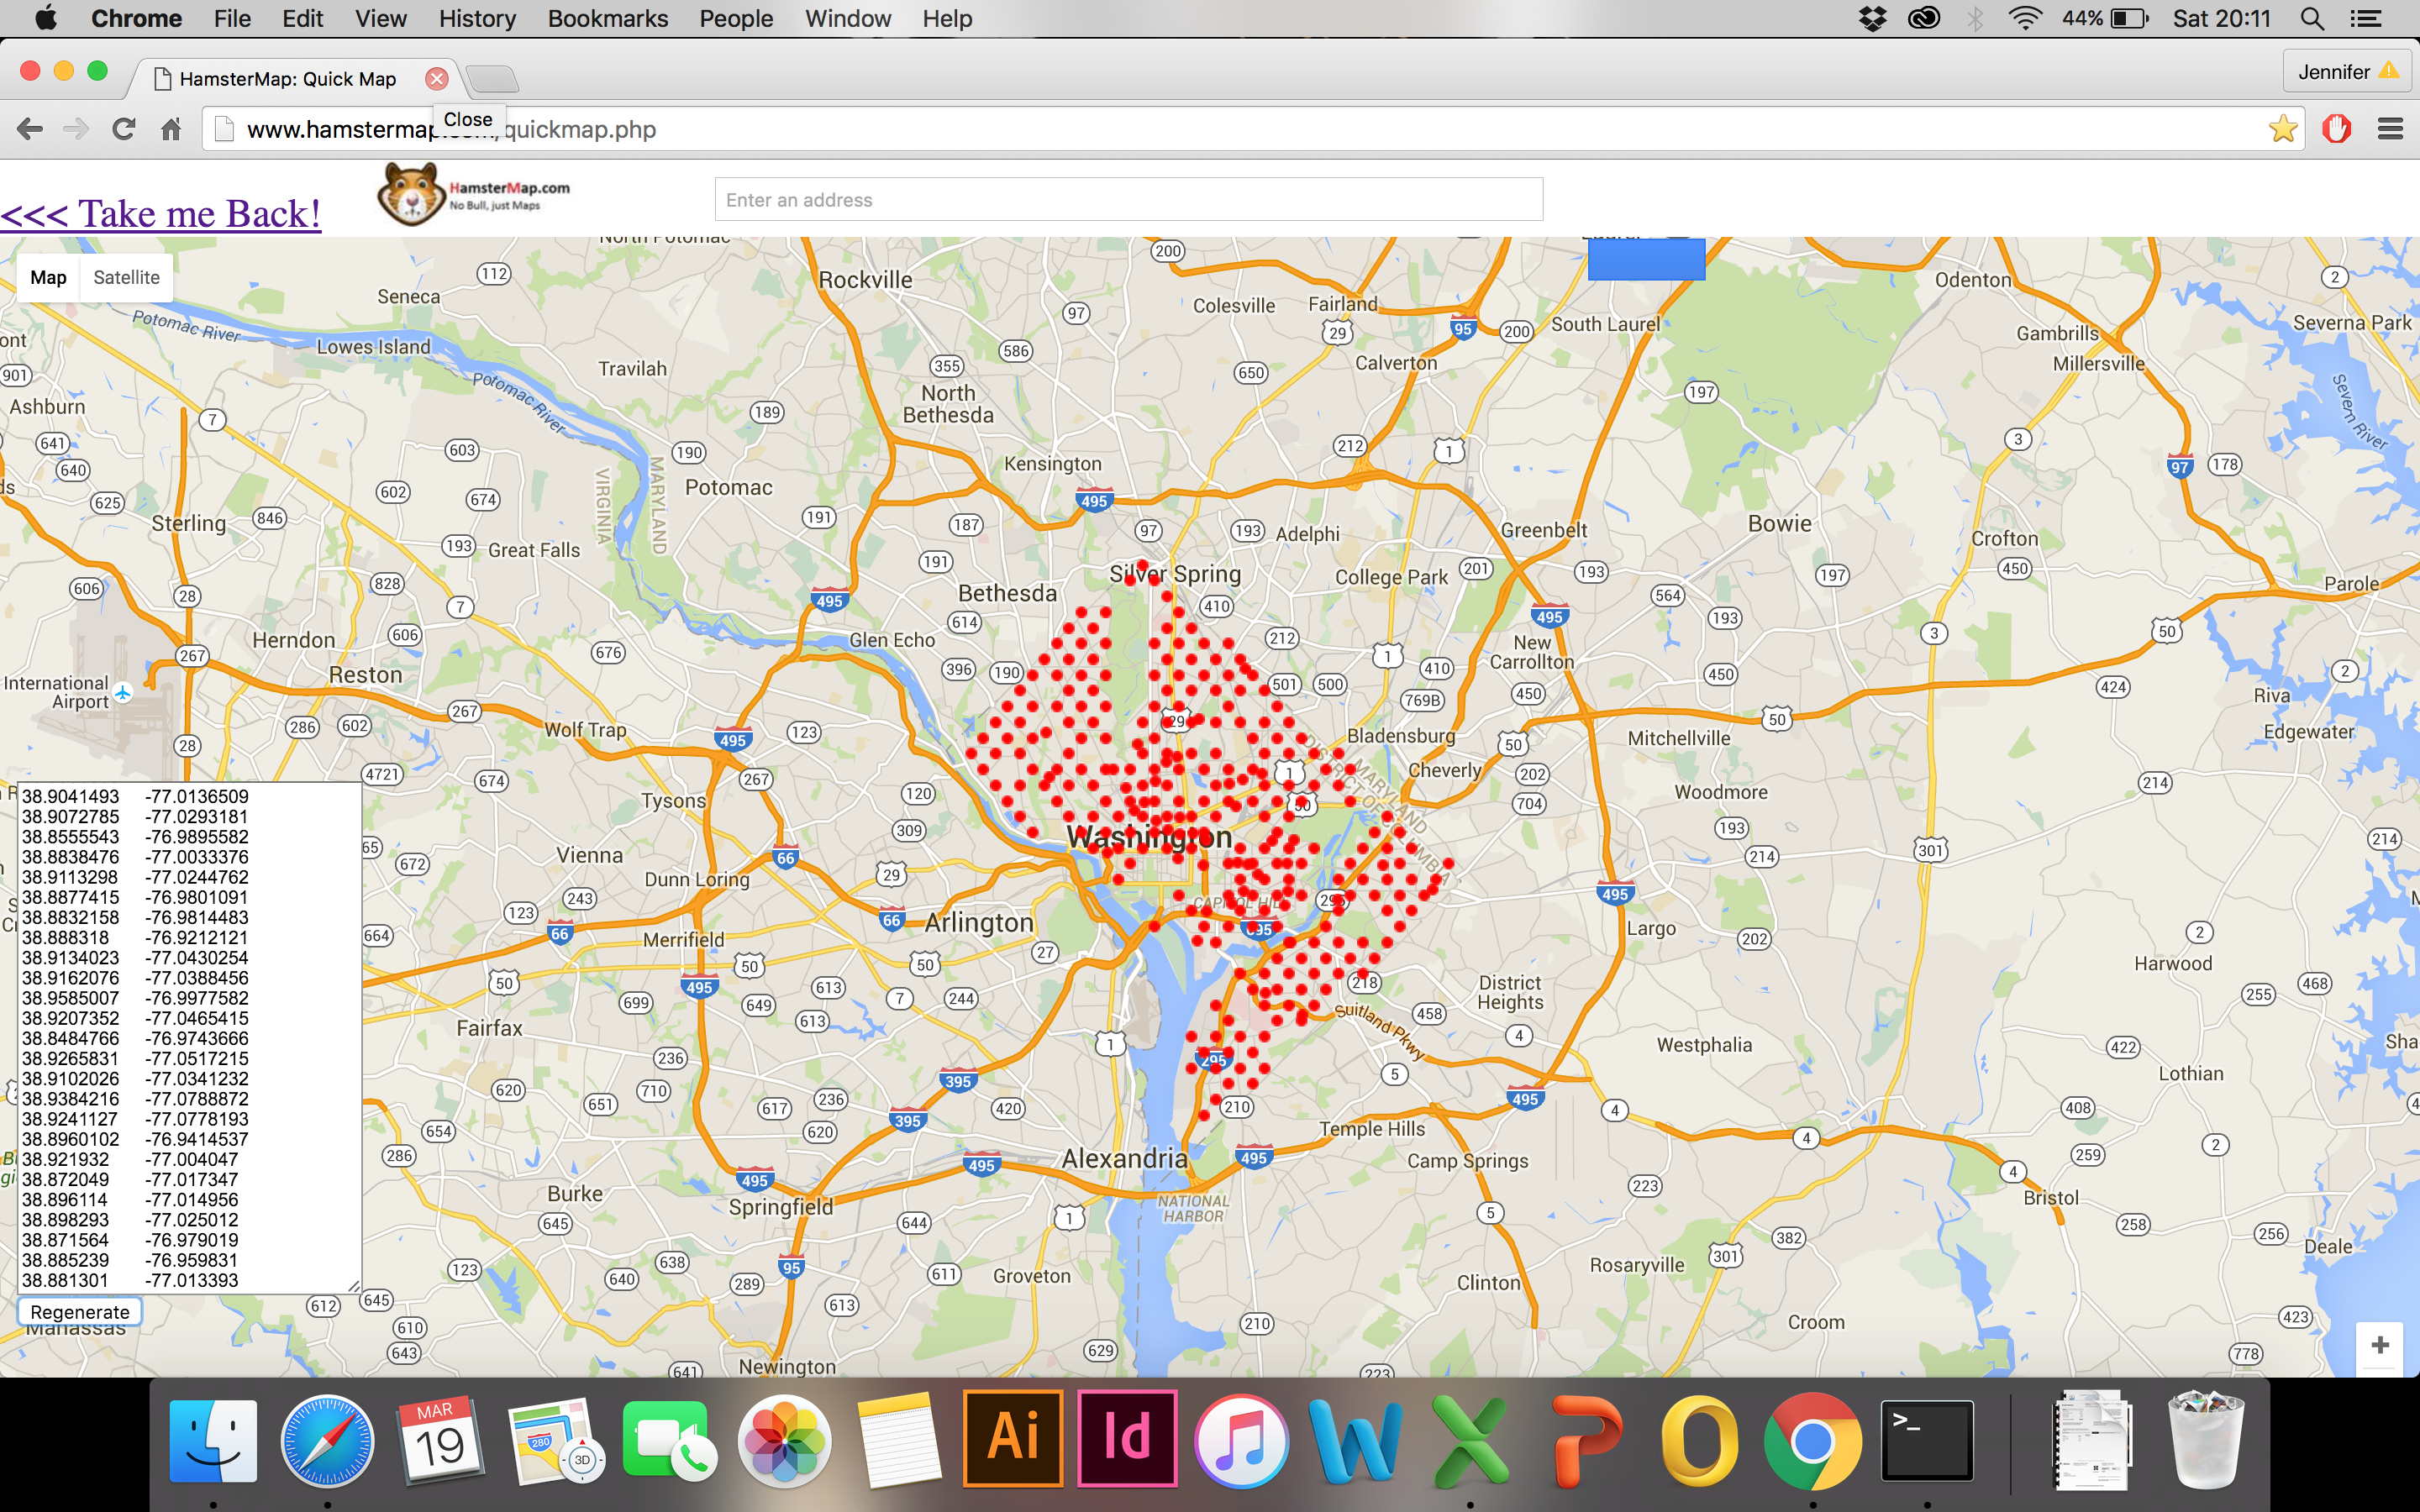

In [47]:
from IPython.display import Image
Image(filename='/Users/jenniferstark/Documents/Repositories/2016-03-wapo-uber/images/validatedPointsMAP.png')

### The points are now absent in water and parkland, and more tightly clustered aound the center where the tracts are smaller

## Convert just the lat-lons to JSON string so that it can be pasted into the config.config file that the Uber API will use, and create baseDF.csv for data analysis

In [48]:
## FINALLY make a new dataframe from which to create the baseDF dataframe for data analysis in UberSurgePricing_OSC.ipynb,
## And the json file data for AWS (amazon web services or whereever it is you'll be running the API):
x = allpoints[['Block', 'latitude', 'longitude']]

## need an extra column counting through the rows. Pandas uses the Index, but
## this does not get recieved by JSON, so we need to make an explicit column:

locs = list(range(0, 277)) # or however many rows there are

x['locations'] = locs

## Now there should be 4 columns:
## lat-lon + locations for JSON, 

awsLocations = x[['latitude', 'longitude','locations']]
awsLocations.to_json('./data/awsLocationsJSON.json', orient='records')
awsLocations.to_csv('./data/awsLocations.csv', index=False)

## and block and location for data analyis

baseDF = x[['Block','locations']]
baseDF.to_csv('./data/baseDF.csv', index=False)

## Then open the json file in, eg. Sublime or Atom. Copy line and paste it into
## AWS's config.config file.

/Users/jenniferstark/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [49]:
awsLocations.head()

latitude  longitude  locations
0  38.821547 -77.009672          0
1  38.831547 -77.019672          1
2  38.831547 -77.009672          2
3  38.831547 -76.999672          3
4  38.831547 -76.989672          4

In [50]:
baseDF.head()

Block  locations
0  110010109001001          0
1  110010073011078          1
2  110010098071011          2
3  110010098021001          3
4  110010097001016          4